**Important Note:**

This notebook relies on a local python module developed by the author. The file , called `common_scope.py`, should be in the same directory.

A copy of the contain of the module is provided at the end of this notebook. 



In [1]:
# run this cell only when loaded from Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# change the working directory
#%cd /content/drive/MyDrive/OpenDoor

In [3]:
# to update scikit-learn
#%pip install -U scikit-learn

# Predicting Common Scope

To predict common scope from home characteristics, I developed a simple `Python` module, stored in a separate file named: [`common_scope.py`](common_scope.py). This python module contains all the necessary functionalities to load, and preprocess the data, as well as modeling and predicting labels.

The main class in the module is called `CommonScope` which includes the engine.

In this vignette, I will explain how to use the class and then I apply the method on the holdout data.

<img src="./images/house.png" alt="House" align="right" style="width: 200px;"/>



### Loading `Matplotlib`

As most of the class are loaded and used in the `CommonScope` module, here I only import `matplotlib` for visualizations.



In [4]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [5]:
# configuration of matplotlib

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.rcParams.update({'font.size': 16})

In [6]:
# helper function

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

### Usage

In addition to importing my `CommonScope` class, I also import a stand-alone function, called `summarize`, located in the module. The main goal of `summarize` is to provide a summary of columns and data types in the training and hold-out datasets.


In [7]:
from common_scope import CommonScope, summarize

To better understand the underlying procedure of our class, please refer to the module file: [`common_scope.py`](common_scope.py). 

The module, its class, methods and functions are documented using standard `Python Docustring`, as suggested by [PEP 257](https://www.python.org/dev/peps/pep-0257/).

### `CommonScope` class instantiation

**Method I**:
The basic method to instantiate the class is very straight-forward by passing the train and hold out files.

The data files get processed and loaded in the class. If any exception occurs, it will be caught and messaged to the user.

In [8]:
# loading the class at the time of creating the instance

cs = CommonScope(model = 'Lasso',
                 drop_colinears  = False,
                 train_file = 'data/development_df.csv', 
                 holdout_file = 'data/holdout_candidate_df.csv')


"data/development_df.csv" was loaded as the training data set: 10919 x 40
"data/holdout_candidate_df.csv" was loaded as the hold-out data set: 1580 x 39


If things go well, the user sees success messages similar to above.

**Method II**:
Alternatively, these can be done in three steps for more transparency, as follows:

In [9]:
# class instantiation
cs = CommonScope(model = 'Ridge')

# loading the training file
cs.load_data(file_path='data/development_df.csv')

# loading the holdout file
cs.load_data(file_path='data/holdout_candidate_df.csv', holdout = True)


"data/development_df.csv" was loaded as the training data set: 10919 x 40
"data/holdout_candidate_df.csv" was loaded as the hold-out data set: 1580 x 39


### Exploring the data

To facilitate data exploration, I have customized a method to summarize, data-type, number of unique values and missing fraction for each column in the data. This helps to decide about the modeling structure.

The functionality can be accessed using the `summary` method.

In [10]:
# summarizing the training data

summarize(cs.train_data)

,column_name,data_type,unique_values,percent_missing
has_renovation,has_renovation,bool,2,0.000000
in_gated_community,in_gated_community,bool,2,0.000000
renovation_amount,renovation_amount,int64,40,0.000000
pool,pool,float64,2,0.000000
total_finished_sq_ft,total_finished_sq_ft,float64,2520,0.000000
above_grade_sq_ft,above_grade_sq_ft,float64,2454,0.000000
age,age,float64,61,0.000000
f_days_since_prev_close,f_days_since_prev_close,float64,3910,0.000000
common_scope,common_scope,float64,9032,0.000000
bedrooms,bedrooms,float64,7,0.009158


Similarly, I can quickly explore the hold out data

In [11]:
# summarizing the holdout data
holdout_summary = summarize(cs.holdout_data)

## Data Challenges

There are several challenges of this dataset, that I summarize as follows:

1. Missing data
2. Multifarious data (various types)
3. Multi-Colinearity


### 1. Missing Data
I followed several approaches to address missing data problem:
 - For few columns with more than 40% missing data, I dropped the column.
 - For `integer` data types, I replaced the missing data with the `median` value on the training dataset
 - For `float` data types, I replaced the missing data with the `mean` value on the training dataset
 - For `object` data types, I replaced the missing data with the `most frequent` value on the training dataset
 
**Note:** The gap-filling process was fit on the `training` dataset and then transform on both the `training` and `holdout` data. 
 
 
### 2. Multifarious data (various types)

The original data was in various types, including: `boolean`, `integer`, `float`, `categorical` and `raw (unparsed) text`. Therefore, the data should be preprocessed to be used in the model. I took the following approach:
- `boolean` data were transformed to 0 for False and 1 for True values.
- `integer` data were used as is.
- `float` data were used as is.
- `categorical` data were transformed to binary matrices, i.e. One-Hot-Encoding.
- `raw (unparsed) text` data were first parsed to extract features and then used as binary matrices.


### 3. Multi-Colinearity:
I took two approaches to tackle this issue:
 - Using [Regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics)) and regression method such as *[Lasso](https://en.wikipedia.org/wiki/Lasso_(statistics))* or *[Ridge](https://en.wikipedia.org/wiki/Tikhonov_regularization)* Regression methods.
 - or dropping the highly correlated features. 
 
**For the second approach:** 
After preprocessing the feature matrix, I dropped colinear feature using our embedded routine based on a [Variance Inflation Factor](https://en.wikipedia.org/wiki/Variance_inflation_factor) threshold.

This procedure is performed inside the `drop_colinearity` function in the `CommonScope` module.


### 4. Positive-Only Values:
Another modeling challenge is that, regression methods are not bound between limits. However, the common scope estimates can not be negative. A general solution is to transform the values using natural log function. This has been in fact incorporatred in the recent `scikit-learn` packages by passing `positive = True` to the model constructor. 



## Modeling

In the `CommonScope` Class, I implemented three different models as options: Linear Regression, Lasso Regression and Ridge Regression. All three can be easily called either when the `__init__` constructor is called or when the `fit` method is called. 

In addition to the these regression models, I also implemented a Neural Network in TensorFlow which does not show significant improvements over the regression methods.

However, I took one step further and only for comparison purposes, I trained an AutoML model on `Google Cloud Platform`. The main challenge for AutoML, however, is that there is little control on model tuning. And there would be an additional cost for modeling and predictions as well as for I/O. So I only compared the results from AutoML to the results from my home-grown `CommonScope` module.


In [12]:
cs.fit(verbose = True, 
       model_pars = {'positive': True, 
                     'alpha': .2},
       model = 'Lasso')

{'train': {'R²': 0.34431613749556433, 'MAE': 3633.5876029172587, 'rMSE': 5046.289487018266}, 'test': {'R²': 0.3518650354946905, 'MAE': 3545.394468202433, 'rMSE': 4846.795866542509}}


{'model': Lasso(alpha=0.2, normalize=True, positive=True),
 'model_summary': {'train': {'R²': 0.34431613749556433,
   'MAE': 3633.5876029172587,
   'rMSE': 5046.289487018266},
  'test': {'R²': 0.3518650354946905,
   'MAE': 3545.394468202433,
   'rMSE': 4846.795866542509}}}

## Analyzing the Predictions

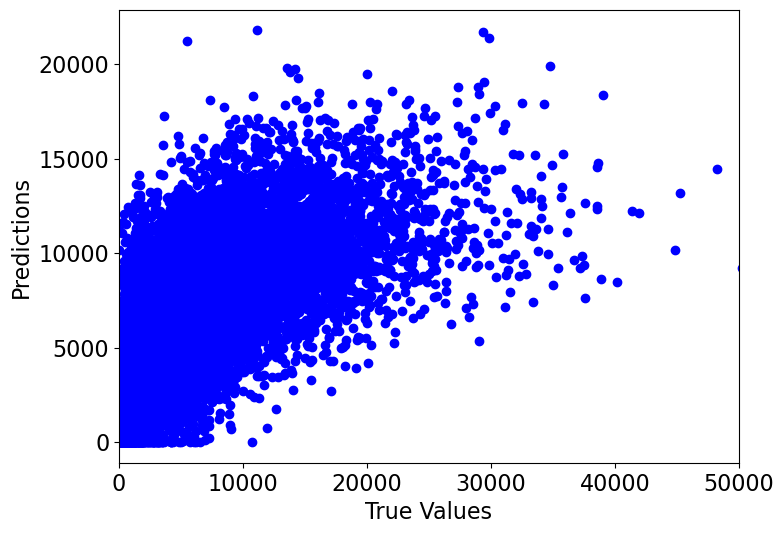

MAE = $3592.46
rMSE = $4997.56
R2 = 0.35


In [13]:
train_trues = cs.train_data.common_scope
train_preds = cs.predict(cs.train_data)

plt.plot(train_trues, 
         train_preds, 
         'o', 
         color='blue')

plt.xlabel("True Values")
plt.ylabel("Predictions")

plt.xlim(0, 50000)

plt.show()

print(f'MAE = ${mean_absolute_error(train_trues, train_preds):.2f}')
print(f'rMSE = ${mean_squared_error(train_trues, train_preds)**0.5:.2f}')
print(f'R2 = {r2_score(train_trues, train_preds):.2f}')



In [14]:
(train_preds).shape

(10919,)

## Predictions for the Hold-out Data

In [15]:
holdout_preds = cs.predict(df= cs.holdout_data)



In [16]:
holdout_preds = cs.predict(df= cs.holdout_data)

holdout_preds = pd.DataFrame({'flip_token': cs.holdout_data.flip_token.to_list(),
                             'prediction': holdout_preds.reshape(len(holdout_preds))})

holdout_preds.head()



,flip_token,prediction
0,560EQGK7A1YM,10254.794661
1,N283R19X7QWF,8490.249340
2,7HNA53BSS2D92,5235.385524
3,NN5R58HDGFB2,1826.118206
4,2XDMCE3HDXNNP,13489.127581


### Exporting the predictions

In [17]:
holdout_preds.to_csv('data/holdout_predictions.csv', 
                     index = False)

## Comparison Our Model vs. AutoML

Below I compare the results from my model with results from an AutoML that I trained on GCP. Both models were applied on holdout dataset.

The results showed AutoML predictions are very similar to the model shown here.  

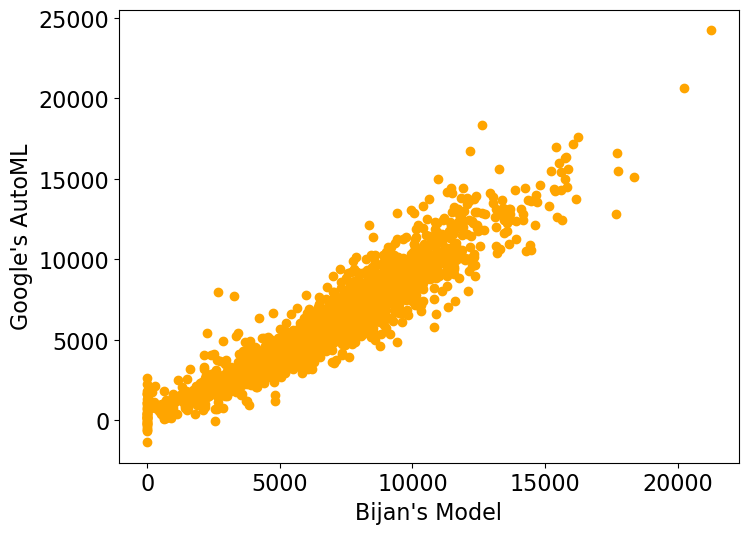

R2 =  0.8175241247605917


In [18]:
automl_pred_holdout = pd.read_csv('data/holdout_predictions_automl.csv')

bijan_vs_automl = holdout_preds.merge(automl_pred_holdout, 
                                      on= 'flip_token')

plt.plot(bijan_vs_automl.prediction, 
         bijan_vs_automl.automl_predictions, 
         'o', 
         color='orange')

plt.xlabel("Bijan's Model")
plt.ylabel("Google's AutoML")

plt.show()

print('R2 = ', r2_score(bijan_vs_automl.prediction, 
                   bijan_vs_automl.automl_predictions))

# Analyzing for the Business Value (BV)

### What we know:

- For every $150 in repair charge we can expect to have a 1% withdrawal rate.

- Every home Opendoor acquires translates to $5000 in profit on average

- Eliminate inspections may reduce withdrawal rates by 5 percentage points.

In [19]:
# putting these in numbers

withdrawal_rate_per_cost = 0.01 / 150 
profit_per_sale = 5000
reduced_withdrawal_for_convenience = 0.05
#average_gain = (train_preds. - train_trues).mean()
average_gain = (train_trues.values - train_preds.reshape(len(train_preds))).mean()

# Back of the Envolope Calculations for BV

In [20]:
# calculating avergae gain if predictions were used instead of true estimates
increased_withdrawal_for_cost = average_gain*withdrawal_rate_per_cost
net_model_gain = average_gain + profit_per_sale * (reduced_withdrawal_for_convenience - increased_withdrawal_for_cost) 

ideal_profit = profit_per_sale
current_net_profit = profit_per_sale * (1- train_trues.mean() * withdrawal_rate_per_cost)
model_net_profit = average_gain + profit_per_sale * (1 - train_preds.mean() * withdrawal_rate_per_cost + reduced_withdrawal_for_convenience)



printmd(f'## On average the change in estimates is {average_gain:.2f} USD,')
printmd(f'## \
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; \
        which is equivalent of {average_gain:.2f} USD.')


printmd(f'## Changed withdrawal for estimates change: {increased_withdrawal_for_cost*100:.2f}%')
printmd(f'## \
                &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; \
        which is equivalent of {- profit_per_sale * increased_withdrawal_for_cost:.2f} USD.')

printmd(f'## Decreased withdrawal for convenience: {reduced_withdrawal_for_convenience*100:.2f}%')
printmd(f'## \
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; \
        which is equivalent of {profit_per_sale * reduced_withdrawal_for_convenience:.2f} USD.')


print('\n\n')

printmd(f"## In other words:")

printmd(f"## If every request was completed, then the ideal net profit was: ${ideal_profit:.2f}.")
printmd(f"##  But because of withdrawal, the current net profit is: ${current_net_profit:.2f}.")
printmd(f"##  If we use the model estimates, the net profit will be: ${model_net_profit:.2f}.")

print('\n\n\n')


printmd(f'# This is a total of ${net_model_gain:.2f} net gain in profit, \
            or %{net_model_gain / current_net_profit * 100:.2f}.')

print('\n\n\n')



## On average the change in estimates is -45.73 USD,

##         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;         which is equivalent of -45.73 USD.

## Changed withdrawal for estimates change: -0.30%

##                 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;         which is equivalent of 15.24 USD.

## Decreased withdrawal for convenience: 5.00%

##         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;         which is equivalent of 250.00 USD.

## In other words:

## If every request was completed, then the ideal net profit was: $5000.00.

##  But because of withdrawal, the current net profit is: $2652.52.

##  If we use the model estimates, the net profit will be: $2841.55.

# This is a total of $219.51 net gain in profit,             or %8.28.

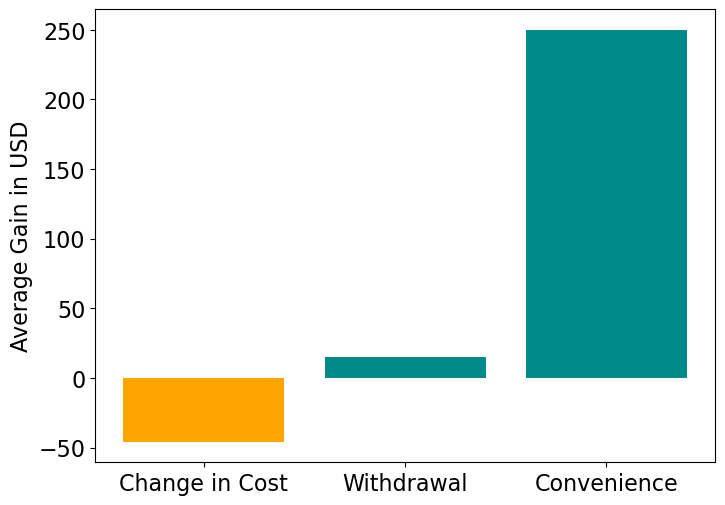

In [21]:

labels = ['Change in Cost', 'Withdrawal', 'Convenience']

gain_loss = [average_gain, 
        - profit_per_sale * increased_withdrawal_for_cost, 
        profit_per_sale * reduced_withdrawal_for_convenience]

plt.bar(labels, gain_loss, color = ['orange', 'darkcyan', 'darkcyan'])
plt.ylabel('Average Gain in USD')
plt.show()

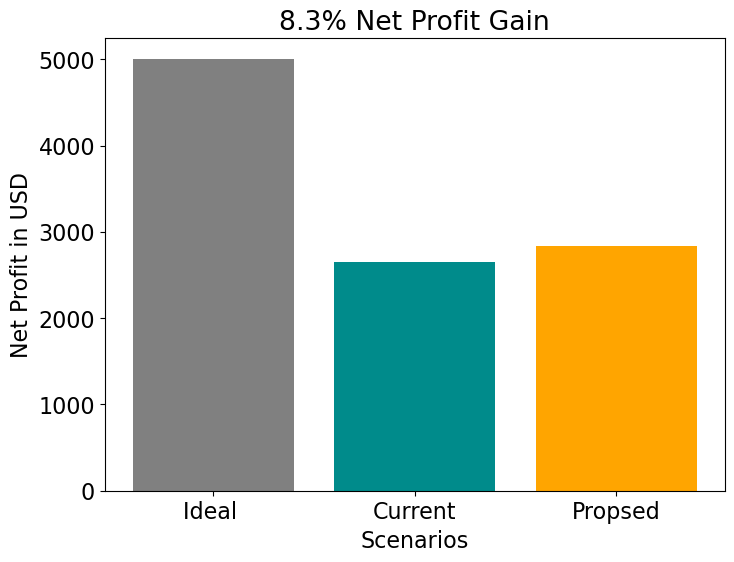

In [22]:

labels = ['Ideal ', 'Current', 'Propsed']

gain_loss = [profit_per_sale, 
             current_net_profit,
             model_net_profit]

plt.bar(labels, gain_loss, 
        color = ['grey', 'darkcyan', 'orange'])
plt.ylabel('Net Profit in USD')
plt.xlabel('Scenarios')
plt.title(f'{net_model_gain / current_net_profit * 100:.1f}% Net Profit Gain')
plt.show()

# Solutions:

As our crude model showed significant improvement over the traditional estimation methods, I believe our analysis proves that there is a business value in providing modeled estimates at the time of offer.  

Therefore, I propose a road map with two major milestones as follows:

## V0 solution (1 Month)
Our analysis is purely data-driven, so the quality and quantity of the data would have strong impact on the performance and accuracy of the model. 

As the first step, the following steps are proposed as a road map:

- Improve data quality 
- Increase the coverage
- Diversify the data as much as possible
- Utilize external datasets, especially localized datasets for each market
- Apply the new data data to th
- Report how the model predictions have (likely) improved with the new dataset

By the end of this milestone, an improved, more diverse and larger dataset is applied to the model.

## V1 solution (1 Quarter)
After improving the data quality and quantity and identifying most important features, we should evaluate the model via the following steps:


- Perform a sensitivity analysis of the model to each variable
- Identify the most important features interacting with each other
- Include interaction effects in the features
- Perform a model selection analysis such as [Akaike Information Criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion)
- Identify where (and possibly why) the model suffers the most
- Diagnose the model for underestimations at the higher end


By the end of this milestone, the model has been improved and an improved, more diverse and larger dataset is applied to the improved model.




In [23]:
'''
Author: Bijan Seyednasrollah
Date: March 31, 2021

Python module to load, preprocess, and analyze common scope estimates based on home features.

The purpose of this module is to facilitate data modeling for common scope estimates.

'''

import pandas as pd
import numpy as np
import logging

import re

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import Normalizer, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor    


def summarize(df):
    '''
    Takes in a dataframe, returns a summary table of the following:
        - column_name
        - data_type
        - unique_values
        - percent_missing
        
    Args:
        df (pandas dataframe): input dataframe
        
    Returns:
        pandas dataframe: The return value
    '''

    columns_summary = pd.DataFrame({'column_name': df.columns,
                                    'data_type': df.dtypes,
                                    'unique_values': df.nunique(),
                                    'percent_missing': df.isnull().sum() * 100 / len(df)})

    columns_summary = columns_summary.sort_values( by = ['data_type', 'percent_missing'])

    return columns_summary


def drop_colinearity(df, 
                     verbose = False,
                     thresh=10.0):
    
    '''
    Takes in a dataframe, drops colinear columns and retruns the rest.
        
    Args:
        df (pandas dataframe): input dataframe
        verbose (boolean): whether print out the progress
        threshold (float): maximum VIF score
    Returns:
        pandas dataframe: The return dataframe
    '''
    
    variables = list(range(df.shape[1]))
    dropped = True
    
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(df.iloc[:, variables].values, ix)
               for ix in range(df.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            if verbose:
                print('dropping \'' + df.iloc[:, variables].columns[maxloc] +
                      '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    
    return variables



class CommonScope:
    '''
    Common scope data are loaded, trained and predicted in one place.
    
    Args:
        train_file (string): file path to the training dataset
        holdout_file (string): file path to the holdout dataset
        drop_colinears (bool): whether to drop colinear variables based on VIF.
        model (string): "LinearRegression", "Lasso", "Ridge" or a model function.

    
    Attributes:
        train_file (string): file path to the training dataset
        holdout_file (string): file path to the holdout dataset        
        columns (dict): dictionary of column names with their type
        train_data (dataframe): training dataset
        holdout_data (dataframe): holdout dataset
        imputers (dict): imputers for the data types
        preprocessed_feature (dataframe): preprocessed training features data
        drop_colinears (bool): whether to drop colinear variables based on VIF.
        model (string): "LinearRegression", "Lasso", "Ridge" or a model function.
    '''
    
    def __init__(self, 
                 train_file = None,
                 holdout_file = None,
                 drop_colinears = False,
                 model = 'LinearRegression'
                ):
        
        self.train_file = train_file
        self.holdout_file = holdout_file
        
        self.columns = self.__group_columns()
        
        self.train_data = None
        self.holdout_data = None
        self.imputers = None
        self.preprocessed_feature = None
        self.included_variables = None
        self.drop_colinears = drop_colinears
        self.model = model
        
        if train_file is not None:
            self.load_data(file_path = train_file)
        
        if holdout_file is not None:
            self.load_data(file_path = holdout_file, holdout = True)
        

    def __extract_feature_matrix(self, df, column_name):
        '''
        Internal method for parsing feature of bathrooms, bedrooms, etc.
        
        Args:
            input_series (Series): one-dimensional data of features
            
        Returns:
            processed data as binart matrix
        '''
        
        features_list = {'bathroom_features': ['granite_countertops', 'double_sink', 
                                               'separate_shower_tub', 'tile_surround', 
                                               'updated_tile_floors', 'custom_tub_shower'],
                         
                         'kitchen_features': ['stainless_steel_appliances', 'new_cabinets', 
                                              'kitchen_island', 'double_ovens', 'tile_backsplash'],
                         
                         'eligibility_features': ['septic', 'permitted_addition', 
                                                  'history_of_chemical_contamination', 
                                                  'owned_solar_panels', 'leased_solar_panels', 
                                                  'unpermitted_addition', 'age_restricted_community', 
                                                  'flood_history', 'gated_community', 
                                                  'solar_panels', 'known_foundation_issues']}


        input_series = df[column_name]
        
#        long_string = input_series.str.cat(sep=' ')

#        features = set(re.sub(pattern = "\[|\]|'|,|_none_|", 
#                   repl = '', 
#                   string = long_string).split(sep = ' '))

#        features.remove('')
        
        features = features_list[column_name]

        mat = pd.DataFrame(columns = features)

        for feature in mat.columns:
            mat[feature] = input_series.str.contains(feature) * 1

        return mat


    def load_data(self, file_path, holdout = False):
        '''
        Loads data from data file.
        
        Args:
            file_path (string): system path to the data file 
            holdout (bool): True or False whether the data set is holdout

        Returns:
            No return value. The data is loaded in the class.
        '''
        try: 
            df = pd.read_csv(file_path)
        except IOError as err:
            print(err)
            return 
        
        if holdout:
            self.holdout_data = df
            print(f'"{file_path}" was loaded as the hold-out data set: {df.shape[0]} x {df.shape[1]}')
        else:
            self.train_data = df
            print(f'"{file_path}" was loaded as the training data set: {df.shape[0]} x {df.shape[1]}')


    def __group_columns(self):
        '''
        Internal method to classify column names based on their types.
        
        Args: 
            No arguments needed.
        
        Return:
            dict: Data type to lists of column names
        '''
        
        bool_cols = ['has_renovation', 'in_gated_community']

        int_cols = ['bathrooms_full', 'bathrooms_half', 'bedrooms', 'exterior_stories',
                    'garage_spaces', 'pool', 'renovation_amount']

        float_cols = ['total_finished_sq_ft', 'basement_finished_sq_ft', 'sq_ft',
                      'above_grade_sq_ft', 'age', 'f_days_since_prev_close']

        object_cols = ['back_yard_condition', 'bathroom_condition', 'front_yard_condition',
                       'kitchen_appliance_type', 'kitchen_condition', 'kitchen_countertop',
                       'paint_condition', 'primary_floor_condition', 'primary_floor_type', 
                       'secondary_floor_condition', 'secondary_floor_type', 'market_name', 
                       'hvac_age', 'roof_age']

        features_cols = ['bathroom_features', 'eligibility_features', 'kitchen_features']

        date_cols = ['valuation_date']

        excluded_cols = ['flip_token', 'basement_unfinished_sq_ft', 'floor_condition', 
                         'floor_type', 'bathrooms', 'pool_above_ground']
        
        label_col = ['common_scope']
        
        return {'bool': bool_cols,
                'int': int_cols,
                'float': float_cols,
                'object': object_cols,
                'feature': features_cols,
                'date': date_cols,
                'exclude': excluded_cols,
                'label': label_col}

    
    def __set_imputers(self):
        '''
        Internal method to set imputers.
        
        Args:
            No input arguments needed.
        
        Returns:
            dict: Three imputers for integer, float and object columns.
        '''
        
        if self.train_data is None:
            raise('Training data is not loaded yet!')

        df = self.train_data
        
        int_cols = self.columns['int']
        float_cols = self.columns['float']
        object_cols = self.columns['object']

        self.imputers = {'int': SimpleImputer(strategy= 'median').fit(df[int_cols]), 
                         'float': SimpleImputer(strategy= 'mean').fit(df[float_cols]),
                         'object': SimpleImputer( strategy= 'most_frequent').fit(df[object_cols])}

        
    def __preprocessing(self, 
                       df):
        '''
        Internal method to preprocess the data.
        
        Args:
            df (dataframe): input dataframe to get processed.
            
        Retruns:
            dataframe: output processed dataframe.
        '''
        
        if self.train_data is None:
            print('Training data is not loaded yet!')
            return None
        
        int_cols = self.columns['int']
        float_cols = self.columns['float']
        object_cols = self.columns['object']
        date_cols = self.columns['date']
        features_cols = self.columns['feature']
        bool_cols = self.columns['bool']
        
        self.__set_imputers()

        df_imputed_int = pd.DataFrame(self.imputers['int'].transform(df[int_cols]),
                                      columns = df[int_cols].columns)
        
        df_imputed_float = pd.DataFrame(self.imputers['float'].transform(df[float_cols]),
                                                 columns = df[float_cols].columns)

        df_imputed_object = pd.DataFrame(self.imputers['object'].transform(df[object_cols]),
                                                 columns = df[object_cols].columns)
        
        df_imputed_object_dummies = pd.get_dummies(data = df_imputed_object, drop_first=True)

        df_date = pd.concat([pd.to_datetime(df[date_cols].iloc[:,0]).dt.year, 
                   pd.to_datetime(df[date_cols].iloc[:,0]).dt.month, 
                   pd.to_datetime(df[date_cols].iloc[:,0]).dt.day, 
                   pd.to_datetime(df[date_cols].iloc[:,0]).dt.dayofweek], 
                            axis = 1)
        
        df_date.columns = ['valuation_year', 'valuation_month', 'valuation_day', 'valuation_dayofweek']

        df_features_mat = pd.concat([self.__extract_feature_matrix(df, features_cols[0]),
                                    self.__extract_feature_matrix(df, features_cols[1]),
                                    self.__extract_feature_matrix(df, features_cols[2])],
                                    axis = 1)
        
        df_features_mat = df_features_mat.fillna(0)
        
        df_wrangled = pd.concat([df_date, 
                                df[bool_cols]*1,
                                df_imputed_int,
                                df_features_mat,
                                df_imputed_float,
                                df_imputed_object_dummies
                                ], axis = 1)

        df_wrangled = pd.concat([
                                df_wrangled,
                                np.abs(df_wrangled),    
                                df_wrangled**0.5,
                                df_wrangled**2,
                                df_wrangled**3
        ],
                                axis = 1)
        
        return df_wrangled


    def fit(self, 
            test_size = 0.2, 
            random_state = 2020,
            verbose = True, 
            model = None,
            model_pars = {'positive': True,
                        'alpha': 0.1}):
        
        '''
        Fits the training data on the model.
        
        Args:
            test_size (float): between 0-1, fraction of the test data
            random_state (int): random state 
            verbose (bool): True to verbose, False to not verbose
            model (string): "LinearRegression", "Lasso", "Ridge" or a model function.
            model_pars (dict): dictionary of model parameters
        
        Returns:
            model object
        '''
        
        if model is None:
            model = self.model
            
        train_data_processed = self.__preprocessing(self.train_data)

        #identify colienar vairables
        if self.drop_colinears:
            self.included_variables = drop_colinearity(train_data_processed)
        else:
            self.included_variables = list(range(train_data_processed.shape[1]))
        
        features = train_data_processed.iloc[:, self.included_variables]
        
        self.preprocessed_feature = features
        
        if features is None:
            return
        
        labels = self.train_data[self.columns['label']]
        
        X_train, X_test, y_train, y_test = train_test_split(features, 
                                                            labels,
                                                            test_size = test_size, 
                                                            random_state = random_state)
        
        if model == 'LinearRegression':
            model = LinearRegression(
                normalize = True,
                positive = model_pars['positive'] 
            )
            
        elif model == 'Lasso':
            model = Lasso(
                normalize = True,
                positive= model_pars['positive'], 
                         alpha = model_pars['alpha'])
            
        elif model == 'Ridge':
            model = Ridge(
                normalize = True,
                          
                         alpha = model_pars['alpha'])

        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        
        y_test_pred = model.predict(X_test)

        model_summary = {'train': {'R²': r2_score(y_train, y_train_pred),
                                        'MAE': mean_absolute_error(y_train, y_train_pred),
                                        'rMSE': mean_squared_error(y_train, y_train_pred)**0.5},
                              
                              'test': {'R²': r2_score(y_test, y_test_pred),
                                       'MAE': mean_absolute_error(y_test, y_test_pred),
                                      'rMSE': mean_squared_error(y_test, y_test_pred)**0.5}
                             }
        
        self.model = model
        
        self.model_summary = model_summary

        if verbose:
            print(self.model_summary)

        return {'model': model,
                'model_summary': model_summary}

    def predict(self, df):
        '''
        Predicts the labels on a training or holdout data.
        
        Args:
            df (dataframe): with specific format
        
        Returns:
            vector of predicted labels
        '''
        
        if df is None: 
            print('input data is None')
            return
        
        features = self.__preprocessing(df)
        features = features.iloc[:, self.included_variables]
        
        if features is None:
            return 

        model = self.model
            
        labels_pred = model.predict(features)

        labels_pred[labels_pred < 0] =0
        
        return labels_pred